In [1]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import pandas as pd
import scipy as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.preprocessing import StandardScaler
import optuna
import plotly
plotly.offline.init_notebook_mode(connected=False)
import functools
import numpy as np
import pandas as pd

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
train_df.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  
3  -2.9275  10.2922  17.9697  -8.9996  
4   3.9267   9.5031  17.9974  -8.8104  

[5 rows x 202 columns]

In [4]:
# ID + ターゲットのDROP
train_x = train_df.copy().drop('target', axis=1)
train_x = train_x.copy().drop('ID_code', axis=1)
test_x = test_df.copy().drop('ID_code', axis=1)

In [5]:
# ターゲット作成
train_y = train_df[['target']]

In [6]:
def processing(df):
    idx = features = df.columns.values[0:200]
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)
    return df

In [7]:
train_x = processing(train_x)
train_x[train_x.columns[200:]].head()

sum      min      max      mean        std      skew      kurt  \
0  1456.3182 -21.4494  43.1127  7.281591   9.331540  0.101580  1.331023   
1  1415.3636 -47.3797  40.5632  7.076818  10.336130 -0.351734  4.110215   
2  1240.8966 -22.4038  33.8820  6.204483   8.753387 -0.056957  0.546438   
3  1288.2319 -35.1659  38.1015  6.441159   9.594064 -0.480116  2.630499   
4  1354.2310 -65.4863  41.1037  6.771155  11.287122 -1.463426  9.787399   

       med  
0  6.77040  
1  7.22315  
2  5.89940  
3  6.70260  
4  6.94735

In [8]:
test_x = processing(test_x)
test_x[test_x.columns[200:]].head()

sum      min      max      mean        std      skew      kurt  \
0  1416.6404 -31.9891  42.0248  7.083202   9.910632 -0.088518  1.871262   
1  1249.6860 -41.1924  35.6020  6.248430   9.541267 -0.559785  3.391068   
2  1430.2599 -34.3488  39.3654  7.151299   9.967466 -0.135084  2.326901   
3  1411.4447 -21.4797  40.3383  7.057223   8.257204 -0.167741  2.253054   
4  1423.7364 -24.8254  45.5510  7.118682  10.043542  0.293484  2.044943   

       med  
0  7.31440  
1  6.43960  
2  7.26355  
3  6.89675  
4  6.83375

In [9]:
train_x.head()

var_0   var_1    var_2   var_3    var_4   var_5   var_6    var_7   var_8  \
0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187  18.6266 -4.9200   
1  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208  16.5338  3.1468   
2   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427  14.6155 -4.9193   
3  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428  14.9250 -5.8609   
4   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405  19.2514  6.2654   

    var_9  ...  var_198  var_199        sum      min      max      mean  \
0  5.7470  ...  12.7803  -1.0914  1456.3182 -21.4494  43.1127  7.281591   
1  8.0851  ...  18.3560   1.9518  1415.3636 -47.3797  40.5632  7.076818   
2  5.9525  ...  14.7222   0.3965  1240.8966 -22.4038  33.8820  6.204483   
3  8.2450  ...  17.9697  -8.9996  1288.2319 -35.1659  38.1015  6.441159   
4  7.6784  ...  17.9974  -8.8104  1354.2310 -65.4863  41.1037  6.771155   

         std      skew      kurt      med  
0   9.331540  0.101580  1.331023  6.77040  
1  10.336130 -0.351734  4.110215  7.22315  
2   8.753387 -0.056957  0.546438  5.89940  
3   9.594064 -0.480116  2.630499  6.70260  
4  11.287122 -1.463426  9.787399  6.94735  

[5 rows x 208 columns]

### Adversarial validation
testデータが真の分布だと仮定して進める

In [10]:
# importanceの可視化
def importance_hist(df):
    fig = plt.figure(figsize=(12,40))
    ax = fig.add_subplot(111)
    sns.barplot(df['importance'], df['features'])
    ax.set_yticks(np.arange(len(df)))
    ax.set_xlabel('Feature importance')
    ax.set_title('Feature importance')
    plt.savefig("Featureimportance.png", format="png", dpi=500)
    plt.show()

In [11]:
# 学習過程の可視化
def acc_graph(tr_acc,cv_acc):
    fig = plt.figure(figsize=(12,7))
    ax = fig.add_subplot(111)
    ax.plot(tr_acc, label='train accuracy', c='r', linewidth = 5.0)
    ax.plot(cv_acc, label='val accuracy', c='b', linewidth = 5.0)
    ax.set_ylabel('logloss')
    ax.set_xlabel('rounds')
    ax.legend()

In [12]:
# lgb
class LightMod:
    
    def __init__(self):
        self.model = None
        
    def fit(self, train_x, train_y, val_x, val_y):
        params = {'objective': 'binary', 'seed': 71, 'verbose': -1, 'early_stopping_rounds': 50,
                  'metrics': 'binary_logloss', 'lambda_l1': 0.02, 'boosting_type': 'gbdt',
                  'lambda_l2': 0.35, 'num_leaves': 32, 'feature_fraction': 0.8758266694359415, 'bagging_freq': 6,
                  'min_child_samples': 20, 'gamma':0.04, 'learning_rate':0.01, 'num_threads':2}
        num_round = 1000

        lgb_train = lgb.Dataset(train_x, train_y)
        lgb_val = lgb.Dataset(val_x, val_y, reference=lgb_train)
        
        evals_result = {}
        
        self.model = lgb.train(params, lgb_train, num_boost_round=num_round, early_stopping_rounds=1000,
                              valid_names=['train', 'eval'], valid_sets=[lgb_train, lgb_val],
                              evals_result=evals_result)
        
        #　graph
        cv_binary_logloss = evals_result['eval']['binary_logloss']
        tr_binary_logloss = evals_result['train']['binary_logloss']
        acc_graph(tr_binary_logloss,cv_binary_logloss)
        
        importances = pd.DataFrame({'features': self.model.feature_name(), 
                            'importance': self.model.feature_importance(importance_type='gain')}).sort_values('importance', ascending=False)
        importance_hist(importances)
        
        return evals_result, importances
    
    def opt(self, train_x, train_y, val_x, val_y, trial):
        
        lgb_train = lgb.Dataset(train_x, train_y)
        lgb_val = lgb.Dataset(val_x, val_y, reference=lgb_train)
        num_round = 20
        
        objective = 'binary'
        #num_class = 3
        seed = 71
        metrics = 'logloss'
        verbosity = -1
        boosting_type = 'gbdt'
        lambda_l1 = trial.suggest_loguniform('lambda_l1', 1e-8, 10.0)
        lambda_l2 = trial.suggest_loguniform('lambda_l2', 1e-8, 10.0)
        num_leaves = trial.suggest_int('num_leaves', 2, 256)
        feature_fraction = trial.suggest_uniform('feature_fraction', 0.4, 1.0)
        bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.4, 1.0)
        bagging_freq = trial.suggest_int('bagging_freq', 1, 7)
        min_child_samples = trial.suggest_int('min_child_samples', 5, 100)
        learning_rate = trial.suggest_uniform('learning_rate',0.005,0.01)
        gamma = trial.suggest_uniform('gamma',0.01,0.1)
    
        lightgbm_tuna = lgb.LGBMClassifier(
            objective = 'binary',
            #num_class = num_class,
            seed = seed,
            metrics = 'binary_logloss',
            verbosity = verbosity,
            boosting_type = 'gbdt',
            lambda_l1 = lambda_l1,
            lambda_l2 = lambda_l2,
            num_leaves = num_leaves,
            feature_fraction = feature_fraction,
            bagging_fraction = bagging_fraction,
            bagging_freq = bagging_freq,
            min_child_samples = min_child_samples,
            learning_rate = learning_rate,
            gamma = gamma,
            num_threads= 3
        )
        
        lightgbm_tuna.fit(train_x, train_y)
        #lightgbm_tuna = lgb.train(param, lgb_train, num_boost_round=num_round)
        tuna_pred_test = lightgbm_tuna.predict(val_x)  
            
        return (1.0 - (accuracy_score(val_y, tuna_pred_test)))
    
    def predict(self, test_x):
        pred = self.model.predict(test_x)
        return pred

In [13]:
# Adversarial validationのデータセット作成
def adv_make(train_df,test_df):
    adv_train_x = train_df
    adv_test_x = test_df

    # test＝１、train＝０
    adv_train_x['adv_target'] = 0
    adv_test_x['adv_target'] = 1
    # testとtrainの結合
    adv_all_data = pd.concat([adv_train_x, adv_test_x],
                             axis=0).reset_index(drop=True)
    
    # target drop
    all_data_x = adv_all_data.copy().drop('adv_target', axis=1)
    all_data_y = adv_all_data['adv_target']
    
    #X_train, X_test, y_train, y_test = split_data(all_data_x,all_data_y,0.2)
    
    return all_data_x, all_data_y, adv_all_data

In [14]:
# get adv data
adv_X, adv_y, all_data= adv_make(train_x,test_x)

mode select KFold
train LightGBM
${i} fold train


/home/kiiro/anaconda3/envs/python365/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[1]	train's binary_logloss: 0.693126	eval's binary_logloss: 0.693148
Training until validation scores don't improve for 50 rounds
[2]	train's binary_logloss: 0.693106	eval's binary_logloss: 0.693145
[3]	train's binary_logloss: 0.693086	eval's binary_logloss: 0.693143
[4]	train's binary_logloss: 0.693065	eval's binary_logloss: 0.693139
[5]	train's binary_logloss: 0.693046	eval's binary_logloss: 0.693136
[6]	train's binary_logloss: 0.693026	eval's binary_logloss: 0.693133
[7]	train's binary_logloss: 0.693006	eval's binary_logloss: 0.693132
[8]	train's binary_logloss: 0.692986	eval's binary_logloss: 0.69313
[9]	train's binary_logloss: 0.692968	eval's binary_logloss: 0.693129
[10]	train's binary_logloss: 0.692948	eval's binary_logloss: 0.693128
[11]	train's binary_logloss: 0.692929	eval's binary_logloss: 0.693126
[12]	train's binary_logloss: 0.692909	eval's binary_logloss: 0.693122
[13]	train's binary_logloss: 0.69289	eval's binary_logloss: 0.69312
[14]	train's binary_logloss: 0.69287	eval

[117]	train's binary_logloss: 0.690994	eval's binary_logloss: 0.693062
[118]	train's binary_logloss: 0.690975	eval's binary_logloss: 0.693062
[119]	train's binary_logloss: 0.690958	eval's binary_logloss: 0.693062
[120]	train's binary_logloss: 0.690942	eval's binary_logloss: 0.693062
[121]	train's binary_logloss: 0.690925	eval's binary_logloss: 0.693062
[122]	train's binary_logloss: 0.690907	eval's binary_logloss: 0.693064
[123]	train's binary_logloss: 0.690891	eval's binary_logloss: 0.693064
[124]	train's binary_logloss: 0.690874	eval's binary_logloss: 0.693063
[125]	train's binary_logloss: 0.690857	eval's binary_logloss: 0.693063
[126]	train's binary_logloss: 0.690839	eval's binary_logloss: 0.693062
[127]	train's binary_logloss: 0.690821	eval's binary_logloss: 0.693062
[128]	train's binary_logloss: 0.690805	eval's binary_logloss: 0.69306
[129]	train's binary_logloss: 0.690789	eval's binary_logloss: 0.693061
[130]	train's binary_logloss: 0.690771	eval's binary_logloss: 0.693059
[131]	t

[232]	train's binary_logloss: 0.689059	eval's binary_logloss: 0.693007
[233]	train's binary_logloss: 0.689044	eval's binary_logloss: 0.693008
[234]	train's binary_logloss: 0.68903	eval's binary_logloss: 0.693008
[235]	train's binary_logloss: 0.689015	eval's binary_logloss: 0.693008
[236]	train's binary_logloss: 0.688999	eval's binary_logloss: 0.693008
[237]	train's binary_logloss: 0.688984	eval's binary_logloss: 0.69301
[238]	train's binary_logloss: 0.688967	eval's binary_logloss: 0.69301
[239]	train's binary_logloss: 0.68895	eval's binary_logloss: 0.693011
[240]	train's binary_logloss: 0.688934	eval's binary_logloss: 0.693011
[241]	train's binary_logloss: 0.688916	eval's binary_logloss: 0.693009
[242]	train's binary_logloss: 0.688898	eval's binary_logloss: 0.693009
[243]	train's binary_logloss: 0.688881	eval's binary_logloss: 0.693008
[244]	train's binary_logloss: 0.688865	eval's binary_logloss: 0.693008
[245]	train's binary_logloss: 0.688851	eval's binary_logloss: 0.693008
[246]	trai

[347]	train's binary_logloss: 0.68721	eval's binary_logloss: 0.692994
[348]	train's binary_logloss: 0.687196	eval's binary_logloss: 0.692994
[349]	train's binary_logloss: 0.687181	eval's binary_logloss: 0.692993
[350]	train's binary_logloss: 0.687163	eval's binary_logloss: 0.692994
[351]	train's binary_logloss: 0.687145	eval's binary_logloss: 0.692992
[352]	train's binary_logloss: 0.687128	eval's binary_logloss: 0.692994
[353]	train's binary_logloss: 0.687114	eval's binary_logloss: 0.692995
[354]	train's binary_logloss: 0.687097	eval's binary_logloss: 0.692995
[355]	train's binary_logloss: 0.687079	eval's binary_logloss: 0.692995
[356]	train's binary_logloss: 0.687065	eval's binary_logloss: 0.692996
[357]	train's binary_logloss: 0.68705	eval's binary_logloss: 0.692996
[358]	train's binary_logloss: 0.687034	eval's binary_logloss: 0.692998
[359]	train's binary_logloss: 0.687021	eval's binary_logloss: 0.692998
[360]	train's binary_logloss: 0.687004	eval's binary_logloss: 0.692997
[361]	tr

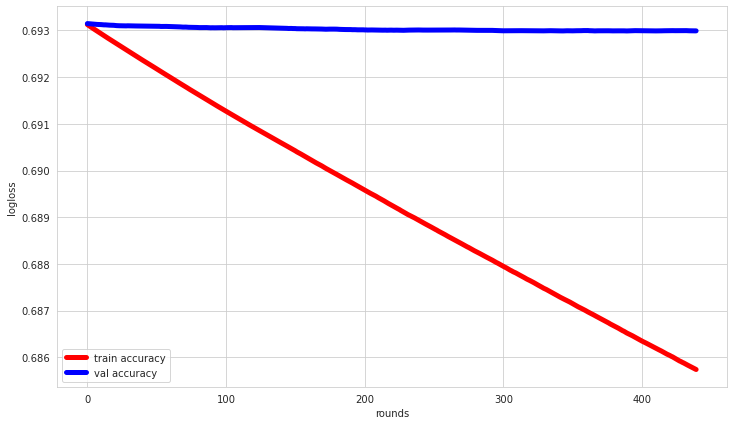

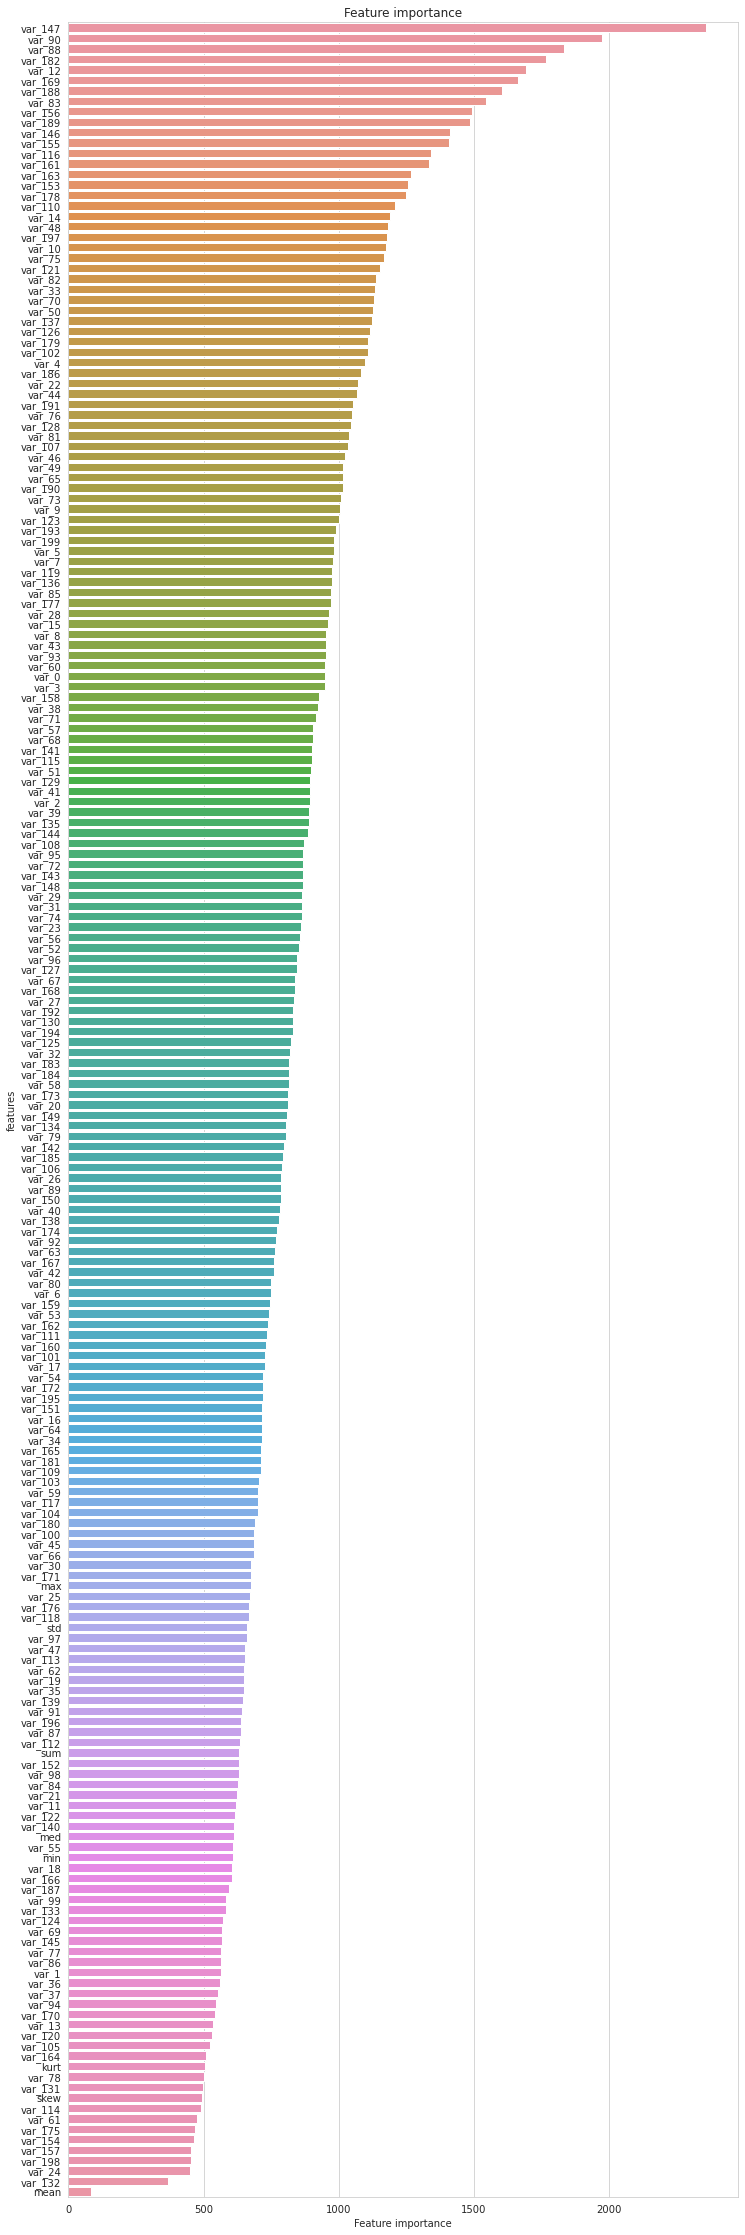

${i} fold train
[1]	train's binary_logloss: 0.693126	eval's binary_logloss: 0.69315
Training until validation scores don't improve for 50 rounds
[2]	train's binary_logloss: 0.693107	eval's binary_logloss: 0.69315
[3]	train's binary_logloss: 0.693087	eval's binary_logloss: 0.693149
[4]	train's binary_logloss: 0.693067	eval's binary_logloss: 0.693149
[5]	train's binary_logloss: 0.693048	eval's binary_logloss: 0.693146
[6]	train's binary_logloss: 0.693028	eval's binary_logloss: 0.693148
[7]	train's binary_logloss: 0.693009	eval's binary_logloss: 0.693147
[8]	train's binary_logloss: 0.69299	eval's binary_logloss: 0.693148
[9]	train's binary_logloss: 0.692971	eval's binary_logloss: 0.693146
[10]	train's binary_logloss: 0.692951	eval's binary_logloss: 0.693147
[11]	train's binary_logloss: 0.692933	eval's binary_logloss: 0.693148
[12]	train's binary_logloss: 0.692915	eval's binary_logloss: 0.693148
[13]	train's binary_logloss: 0.692896	eval's binary_logloss: 0.69315
[14]	train's binary_loglos

[117]	train's binary_logloss: 0.69097	eval's binary_logloss: 0.693068
[118]	train's binary_logloss: 0.690952	eval's binary_logloss: 0.693067
[119]	train's binary_logloss: 0.690934	eval's binary_logloss: 0.693067
[120]	train's binary_logloss: 0.690917	eval's binary_logloss: 0.693066
[121]	train's binary_logloss: 0.6909	eval's binary_logloss: 0.693065
[122]	train's binary_logloss: 0.690883	eval's binary_logloss: 0.693065
[123]	train's binary_logloss: 0.690866	eval's binary_logloss: 0.693065
[124]	train's binary_logloss: 0.690848	eval's binary_logloss: 0.693064
[125]	train's binary_logloss: 0.69083	eval's binary_logloss: 0.693064
[126]	train's binary_logloss: 0.690814	eval's binary_logloss: 0.693064
[127]	train's binary_logloss: 0.690796	eval's binary_logloss: 0.693064
[128]	train's binary_logloss: 0.690778	eval's binary_logloss: 0.693061
[129]	train's binary_logloss: 0.690761	eval's binary_logloss: 0.69306
[130]	train's binary_logloss: 0.690743	eval's binary_logloss: 0.693059
[131]	train

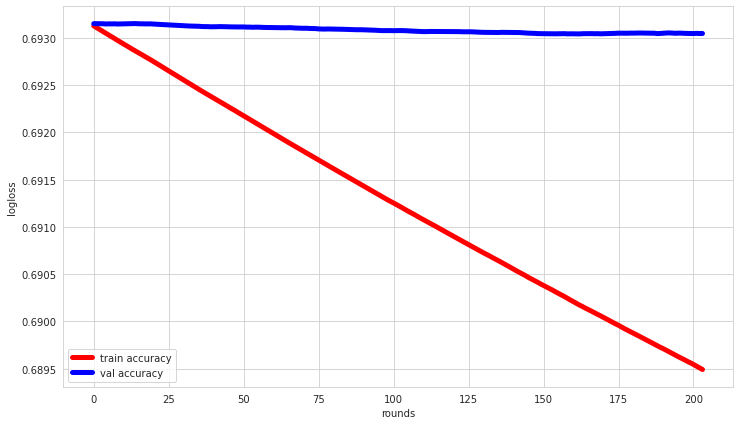

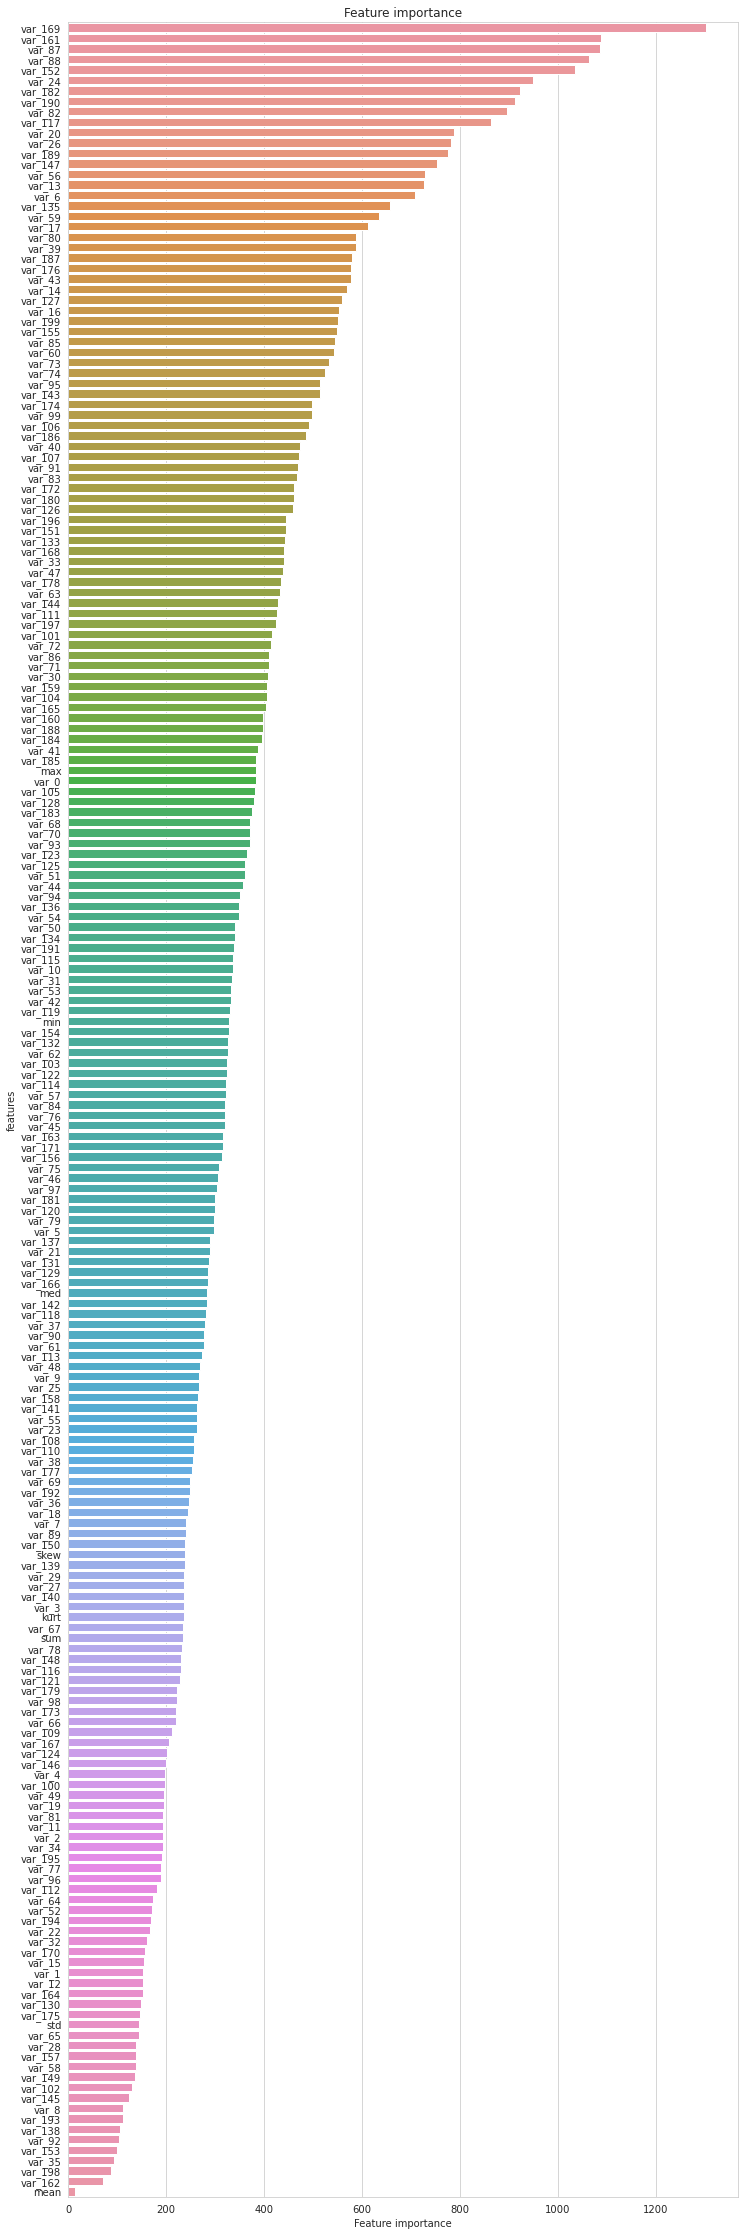

${i} fold train
[1]	train's binary_logloss: 0.693125	eval's binary_logloss: 0.693147
Training until validation scores don't improve for 50 rounds
[2]	train's binary_logloss: 0.693103	eval's binary_logloss: 0.693148
[3]	train's binary_logloss: 0.693082	eval's binary_logloss: 0.693149
[4]	train's binary_logloss: 0.693062	eval's binary_logloss: 0.693149
[5]	train's binary_logloss: 0.693041	eval's binary_logloss: 0.693148
[6]	train's binary_logloss: 0.693021	eval's binary_logloss: 0.693149
[7]	train's binary_logloss: 0.693	eval's binary_logloss: 0.69315
[8]	train's binary_logloss: 0.69298	eval's binary_logloss: 0.693152
[9]	train's binary_logloss: 0.69296	eval's binary_logloss: 0.693153
[10]	train's binary_logloss: 0.692939	eval's binary_logloss: 0.693153
[11]	train's binary_logloss: 0.692919	eval's binary_logloss: 0.693154
[12]	train's binary_logloss: 0.692899	eval's binary_logloss: 0.693153
[13]	train's binary_logloss: 0.692879	eval's binary_logloss: 0.693155
[14]	train's binary_logloss:

[117]	train's binary_logloss: 0.690906	eval's binary_logloss: 0.693136
[118]	train's binary_logloss: 0.690889	eval's binary_logloss: 0.693136
[119]	train's binary_logloss: 0.690871	eval's binary_logloss: 0.693137
[120]	train's binary_logloss: 0.690852	eval's binary_logloss: 0.693134
[121]	train's binary_logloss: 0.690834	eval's binary_logloss: 0.693134
[122]	train's binary_logloss: 0.690814	eval's binary_logloss: 0.693135
[123]	train's binary_logloss: 0.690797	eval's binary_logloss: 0.693133
[124]	train's binary_logloss: 0.690779	eval's binary_logloss: 0.693133
[125]	train's binary_logloss: 0.690763	eval's binary_logloss: 0.693132
[126]	train's binary_logloss: 0.690743	eval's binary_logloss: 0.693131
[127]	train's binary_logloss: 0.690725	eval's binary_logloss: 0.693131
[128]	train's binary_logloss: 0.690707	eval's binary_logloss: 0.69313
[129]	train's binary_logloss: 0.69069	eval's binary_logloss: 0.69313
[130]	train's binary_logloss: 0.690672	eval's binary_logloss: 0.693128
[131]	tra

[232]	train's binary_logloss: 0.688868	eval's binary_logloss: 0.6931
[233]	train's binary_logloss: 0.68885	eval's binary_logloss: 0.6931
[234]	train's binary_logloss: 0.688832	eval's binary_logloss: 0.693101
[235]	train's binary_logloss: 0.688814	eval's binary_logloss: 0.693102
[236]	train's binary_logloss: 0.688798	eval's binary_logloss: 0.693103
[237]	train's binary_logloss: 0.68878	eval's binary_logloss: 0.693103
[238]	train's binary_logloss: 0.688765	eval's binary_logloss: 0.693103
[239]	train's binary_logloss: 0.688746	eval's binary_logloss: 0.693102
[240]	train's binary_logloss: 0.688729	eval's binary_logloss: 0.693101
[241]	train's binary_logloss: 0.68871	eval's binary_logloss: 0.693102
[242]	train's binary_logloss: 0.688693	eval's binary_logloss: 0.693101
[243]	train's binary_logloss: 0.688677	eval's binary_logloss: 0.693099
[244]	train's binary_logloss: 0.688661	eval's binary_logloss: 0.6931
[245]	train's binary_logloss: 0.688642	eval's binary_logloss: 0.693101
[246]	train's b

[347]	train's binary_logloss: 0.686941	eval's binary_logloss: 0.693091
[348]	train's binary_logloss: 0.686925	eval's binary_logloss: 0.693093
[349]	train's binary_logloss: 0.686908	eval's binary_logloss: 0.693093
[350]	train's binary_logloss: 0.686892	eval's binary_logloss: 0.693093
[351]	train's binary_logloss: 0.686874	eval's binary_logloss: 0.693092
[352]	train's binary_logloss: 0.68686	eval's binary_logloss: 0.693093
[353]	train's binary_logloss: 0.686842	eval's binary_logloss: 0.693091
[354]	train's binary_logloss: 0.686826	eval's binary_logloss: 0.69309
[355]	train's binary_logloss: 0.686809	eval's binary_logloss: 0.69309
[356]	train's binary_logloss: 0.686793	eval's binary_logloss: 0.69309
[357]	train's binary_logloss: 0.686776	eval's binary_logloss: 0.693089
[358]	train's binary_logloss: 0.686762	eval's binary_logloss: 0.693089
[359]	train's binary_logloss: 0.686745	eval's binary_logloss: 0.693091
[360]	train's binary_logloss: 0.686728	eval's binary_logloss: 0.69309
[361]	train

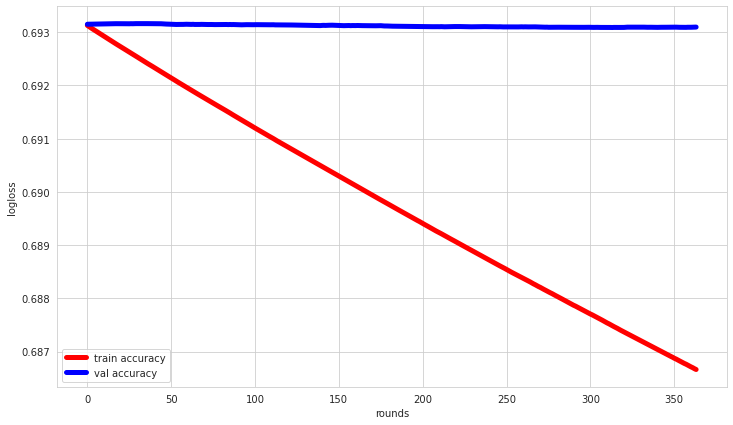

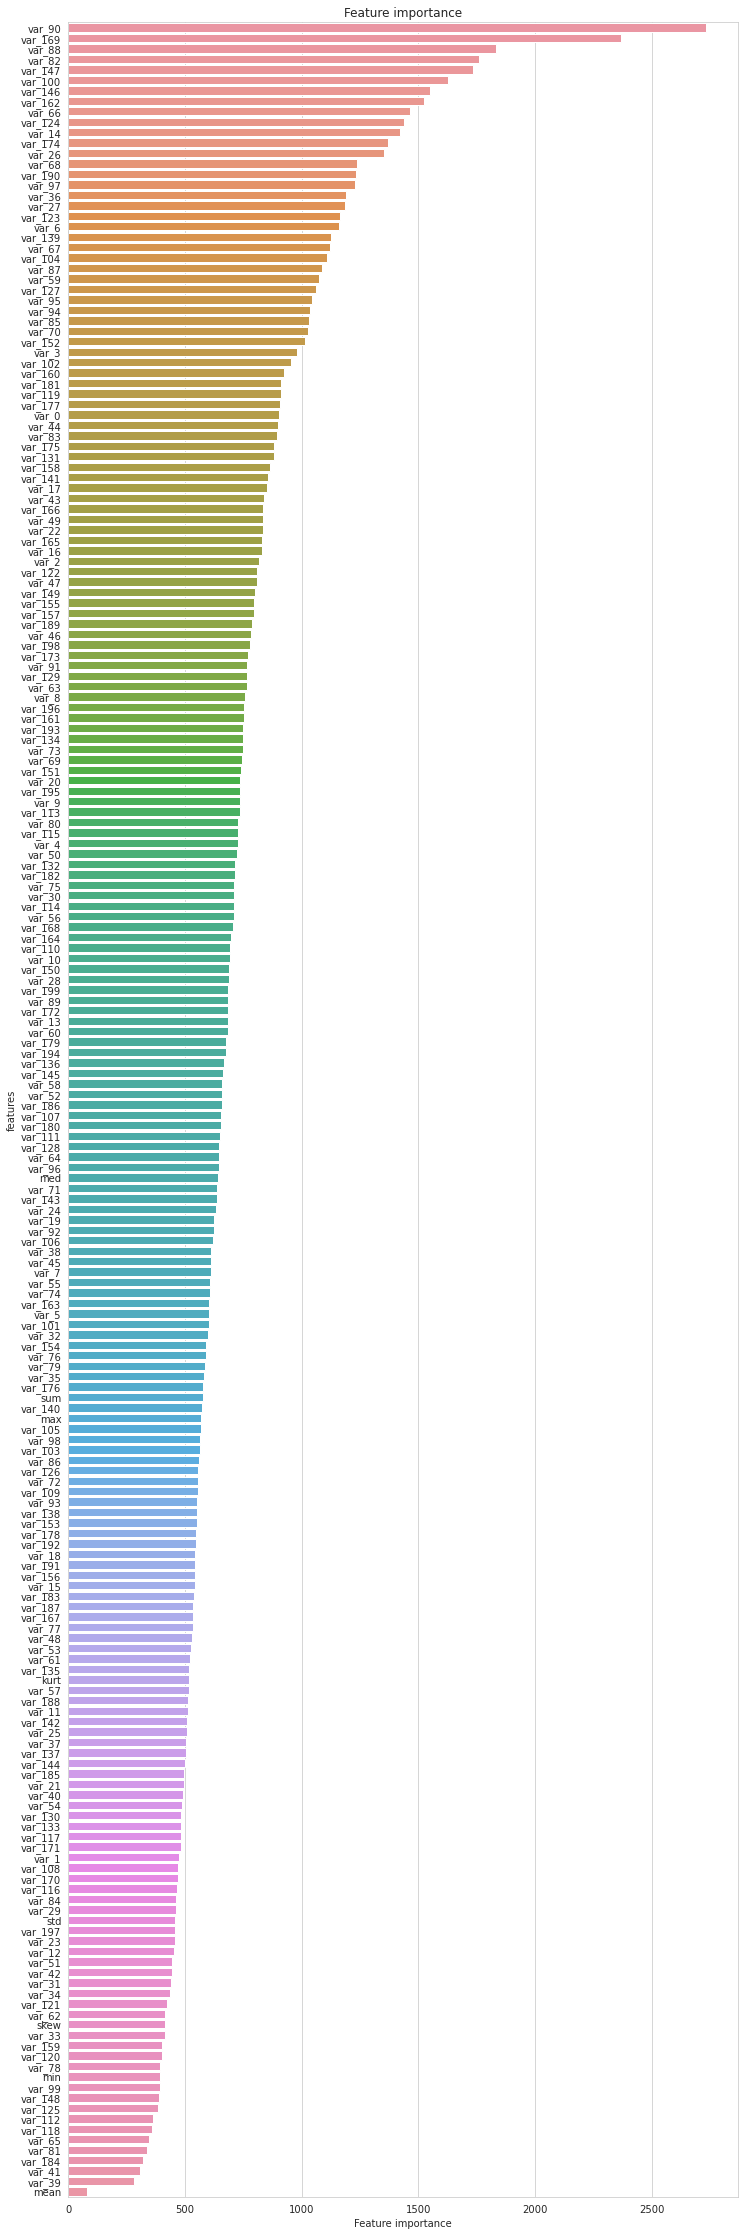

In [15]:
print("mode select KFold")
#skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
L_model = LightMod()
preds = []
preds_test = []
va_idxes = []
oof_pred = np.zeros((len(all_data), ))


print("train LightGBM")
for i, (train_inx, val_inx) in enumerate(kfold.split(adv_X)):
    print("${i} fold train")
    tr_x, va_x = adv_X.iloc[train_inx], adv_X.iloc[val_inx]
    tr_y, va_y = adv_y.iloc[train_inx], adv_y.iloc[val_inx]
    
    # cv_training 
    acc_log, importances = L_model.fit(tr_x, tr_y, va_x, va_y)
    #print(acc_log)         
    
    # cv pred
    pred = L_model.predict(va_x)
    #print(pred)
    # val_score
    preds.append(pred)
    
    # test pred
    #pred_test = L_model.predict(adv_X)
    # test_score
    #preds_test.append(pred_test)
    
    # indexs
    va_idxes.append(val_inx)
    
            
va_idxes = np.concatenate(va_idxes)
preds = np.concatenate(preds, axis=0)
#preds_test = np.concatenate(preds_test, axis=0)

order = np.argsort(va_idxes)
oof = preds[order] 

#preds_test = np.mean(preds_test, axis=0)

In [16]:
# 結果の確認
print(oof)
all_data["Adv_score"] = oof

[0.50504523 0.49584029 0.50712773 ... 0.49995013 0.5028308  0.5079223 ]


In [17]:
# testの分布に近いAdv_score
train = all_data.sort_values("Adv_score", ascending=False)
train.head()

var_0   var_1    var_2   var_3    var_4    var_5   var_6    var_7  \
178629  16.4311  1.9357  10.4754  6.5338  12.4222  11.2145  4.7007  17.2400   
393389   9.4920 -7.2362   5.7873  3.7939  12.1486  -9.9850  4.5551  21.7852   
33338    9.1923  3.8387  13.6496  7.5825  12.9736   4.0308  6.4400  16.1074   
38167    9.3514 -0.8640  13.8242  7.2038   9.7503 -11.7631  5.5273  22.9862   
116059  17.5740 -0.3605   9.3173  6.5372  10.3705 -18.3732  5.0123  18.3833   

         var_8   var_9  ...        sum      min      max      mean        std  \
178629  2.3365  7.6795  ...  1373.0702 -27.1178  34.8870  6.865351   8.670138   
393389 -1.3938  6.7294  ...  1410.4686 -26.2995  46.2879  7.052343   9.924050   
33338   2.4574  6.0910  ...  1452.9989 -46.9213  31.4353  7.264995  10.128104   
38167  -2.8028  7.9765  ...  1352.1399 -30.0863  53.2441  6.760699  10.594149   
116059  3.1151  9.1572  ...  1322.8070 -47.7720  35.2401  6.614035   9.891623   

            skew      kurt      med  adv_target  Adv_score  
178629 -0.508451  1.687318  6.78575           0   0.587993  
393389  0.098777  2.793536  7.14890           1   0.583929  
33338  -0.921258  4.393061  6.86400           0   0.578211  
38167   0.204616  3.153284  6.60430           0   0.576932  
116059 -0.963273  4.910213  7.06520           0   0.574560  

[5 rows x 210 columns]

### データ確認
train&testの可視化の確認　

もし分布が違った場合に行う

In [19]:
train_x.head()

var_0   var_1    var_2   var_3    var_4   var_5   var_6    var_7   var_8  \
0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187  18.6266 -4.9200   
1  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208  16.5338  3.1468   
2   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427  14.6155 -4.9193   
3  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428  14.9250 -5.8609   
4   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405  19.2514  6.2654   

    var_9  ...  var_199        sum      min      max      mean        std  \
0  5.7470  ...  -1.0914  1456.3182 -21.4494  43.1127  7.281591   9.331540   
1  8.0851  ...   1.9518  1415.3636 -47.3797  40.5632  7.076818  10.336130   
2  5.9525  ...   0.3965  1240.8966 -22.4038  33.8820  6.204483   8.753387   
3  8.2450  ...  -8.9996  1288.2319 -35.1659  38.1015  6.441159   9.594064   
4  7.6784  ...  -8.8104  1354.2310 -65.4863  41.1037  6.771155  11.287122   

       skew      kurt      med  adv_target  
0  0.101580  1.331023  6.77040           0  
1 -0.351734  4.110215  7.22315           0  
2 -0.056957  0.546438  5.89940           0  
3 -0.480116  2.630499  6.70260           0  
4 -1.463426  9.787399  6.94735           0  

[5 rows x 209 columns]

In [20]:
test_x.head()

var_0    var_1    var_2   var_3    var_4   var_5   var_6    var_7  \
0  11.0656   7.7798  12.9536  9.4292  11.4327 -2.3805  5.8493  18.2675   
1   8.5304   1.2543  11.3047  5.1858   9.1974 -4.0117  6.0196  18.6316   
2   5.4827 -10.3581  10.1407  7.0479  10.2628  9.8052  4.8950  20.2537   
3   8.5374  -1.3222  12.0220  6.5749   8.8458  3.1744  4.9397  20.5660   
4  11.7058  -0.1327  14.1295  7.7506   9.1035 -8.5848  6.8595  10.6048   

    var_8   var_9  ...  var_199        sum      min      max      mean  \
0  2.1337  8.8100  ...  -8.7197  1416.6404 -31.9891  42.0248  7.083202   
1 -4.4131  5.9739  ... -20.9760  1249.6860 -41.1924  35.6020  6.248430   
2  1.5233  8.3442  ... -23.1794  1430.2599 -34.3488  39.3654  7.151299   
3  3.3755  7.4578  ...  -4.2108  1411.4447 -21.4797  40.3383  7.057223   
4  2.9890  7.1437  ...  -9.1846  1423.7364 -24.8254  45.5510  7.118682   

         std      skew      kurt      med  adv_target  
0   9.910632 -0.088518  1.871262  7.31440           1  
1   9.541267 -0.559785  3.391068  6.43960           1  
2   9.967466 -0.135084  2.326901  7.26355           1  
3   8.257204 -0.167741  2.253054  6.89675           1  
4  10.043542  0.293484  2.044943  6.83375           1  

[5 rows x 209 columns]

In [21]:
# dv_target Drop
train_x = train_x.drop('adv_target', axis=1)
test_x = test_x.drop('adv_target', axis=1)
Adv_score = L_model.predict(train_x)

# スコアを入れる
train_x["Adv_score"] = Adv_score
train_x["target"] = train_y

In [22]:
# Adv_scoreでのソート
train_x = train_x.sort_values("Adv_score",ascending=False)
train_x.head()

var_0   var_1    var_2    var_3    var_4    var_5   var_6    var_7  \
15172   10.2221  1.9434  13.6975   6.1976   8.1854 -11.1479  5.1042  13.1142   
38531   15.8760  1.3697   8.0499   6.8944  12.4163 -11.5702  5.9761  16.0108   
105116  11.7707 -0.4345  12.3102   7.9781  11.8596  -8.4272  4.6101  11.1535   
108931   8.0403 -8.0066  11.8836   9.2145  13.6201 -17.0730  6.6237  14.0818   
77928    9.0248 -1.2113   6.7503  10.7419  13.4666   6.4088  6.1458  17.7492   

         var_8   var_9  ...        sum      min      max      mean        std  \
15172   0.4441  8.2086  ...  1412.1687 -24.1286  38.4920  7.060843   9.370668   
38531  -5.7000  9.6026  ...  1339.3370 -27.5576  41.7659  6.696685   9.454454   
105116 -3.6385  5.9036  ...  1291.1457 -21.3257  37.3033  6.455728  10.605060   
108931 -3.0050  4.9813  ...  1386.3506 -22.0344  33.0660  6.931753   9.334530   
77928  -1.4452  8.4921  ...  1236.0812 -49.6042  36.3969  6.180406   9.974401   

            skew      kurt      med  Adv_score  target  
15172   0.194266  1.487859  6.56845   0.561403       0  
38531  -0.123725  2.149360  7.15150   0.559447       0  
105116 -0.060890  0.620665  6.74035   0.558324       0  
108931 -0.233237  0.923900  7.53905   0.557683       0  
77928  -0.905923  5.072067  6.27915   0.556983       0  

[5 rows x 210 columns]

In [23]:
print(len(train_x))

200000


In [24]:
# 論文内のvalidation Data Selectionに記載
def SMD(df1,df2):
    # 論文内ではSMD < 0.1が推奨されていた
    mean1 = df1.mean()
    mean2 = df2.mean()
    var1 = df1.var()
    var2 = df2.var()
    
    for i in range(len(mean1)):
        mean_diff = abs(mean1 - mean2)
        sd = np.sqrt((var1 + var2) / 2)
        smd = mean_diff / sd
    
    # 結果の表示
    #print("平均の差\n",mean_diff)
    #print("\nSMD\n",smd)
    
    return mean_diff, smd

In [26]:
# validation Data Selection
from tqdm import tqdm

smd_split_scores = []
mean_split_scores = []
val_idxs = []

# train dataを分割しながら、validation_dataとtrainのSMDを計算する。
# SMDの値が低くなった場合は、validation_dataとtrain分布が近いと判断し分割点がきまる。
for valid_idx in tqdm(range(1,len(train_x),200)):
    # validation 
    validation_data = train_x.iloc[:valid_idx]
    train_data = train_x.iloc[valid_idx:]
    
    # val-testの差の計算
    mean_diff,split_smd = SMD(validation_data,test_x)
    
    # Dorp
    split_smd = split_smd.drop("Adv_score", axis=0)
    split_smd = split_smd.drop("target", axis=0)
    #print(split_smd)
    
    # 差の平均を計算
    split_score = split_smd.mean()
    smd_split_scores.append(split_score)
    split_score2 = mean_diff.mean()
    mean_split_scores.append(split_score2)
    
    # 分割点
    val_idxs.append(valid_idx)

100%|██████████| 1000/1000 [09:58<00:00,  1.67it/s]


In [27]:
# 分割点における、SMDの値の数値の推移をプロット
def line_plot(x,y):
    sns.set_style('whitegrid')
    sns.set_context("paper", 1.7, {"lines.linewidth": 4})

    fig = plt.figure(figsize=(12,7))
    ax = fig.add_subplot(111)
    sns.lineplot(x=x, y=y)

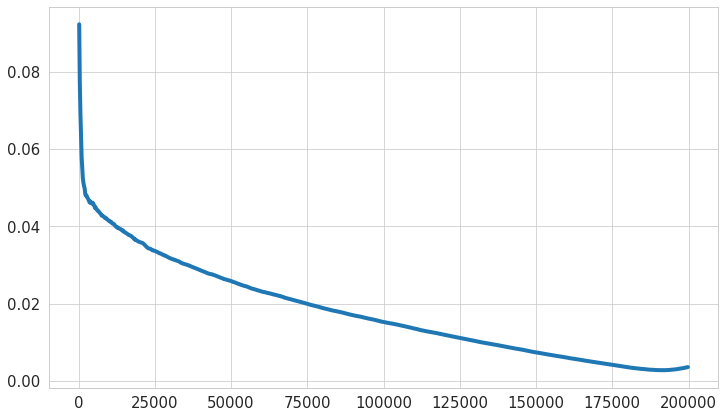

In [29]:
line_plot(val_idxs,smd_split_scores)

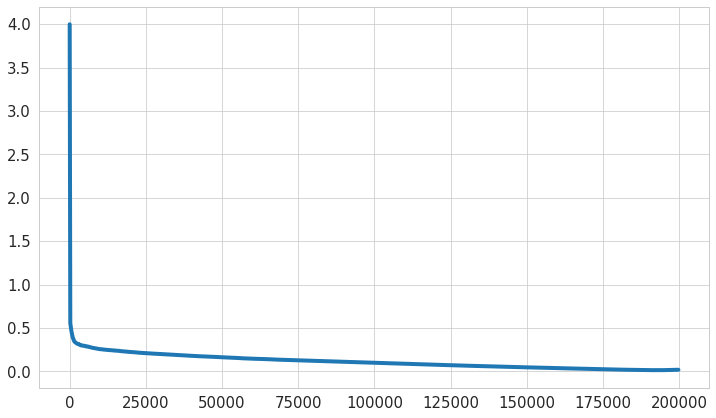

In [30]:
line_plot(val_idxs,mean_split_scores)

In [58]:
# 分布可視化
def two_dist_plot(df1,df2,col,**kwargs):
    feature = df1.columns

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    sns.distplot(df1[feature[col]], label="train", bins=120)
    sns.distplot(df2[feature[col]], label="test" , bins=120)
    ax.set(xlabel ="feature : " + str(feature[col]))
    plt.legend()
    

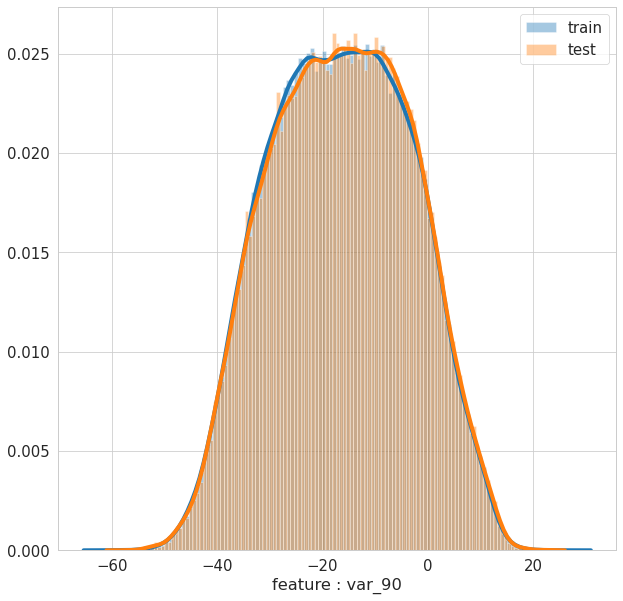

In [59]:
two_dist_plot(train_x,test_x,90)

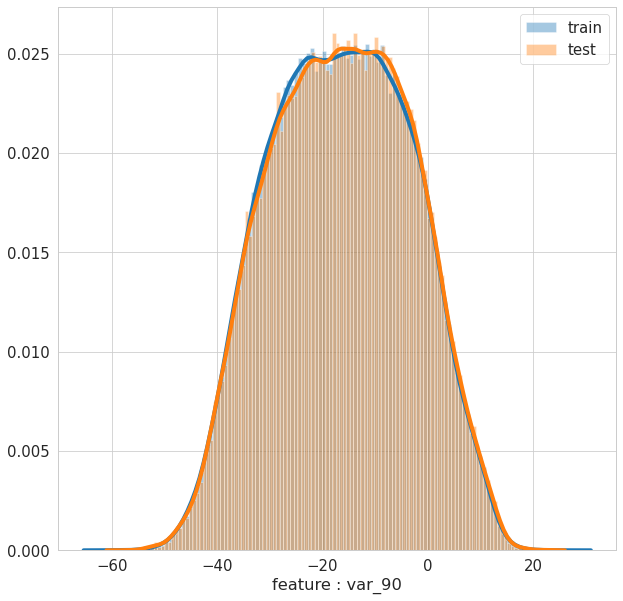

In [65]:
valid_idx = 200000
validation_data = train_x.iloc[:valid_idx]
train_data = train_x.iloc[valid_idx:]
two_dist_plot(validation_data,test_x,90)

In [66]:
# 各特徴量のSMDとmeanの差をプロットする
def dist_plot(df, gtext):
    sns.set_context("paper", 1.3)
    fig = plt.figure(figsize=(12,45))
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(111)

    sns.barplot(df,df.index)
    ax.set_yticks(np.arange(len(df)))
    ax.set_xlabel(gtext)
    ax.set_title(gtext + ' graph')
    plt.savefig(gtext + ".png", format="png", dpi=500)
    plt.show()

In [67]:
mean_diff, smd = SMD(train_x,test_x)

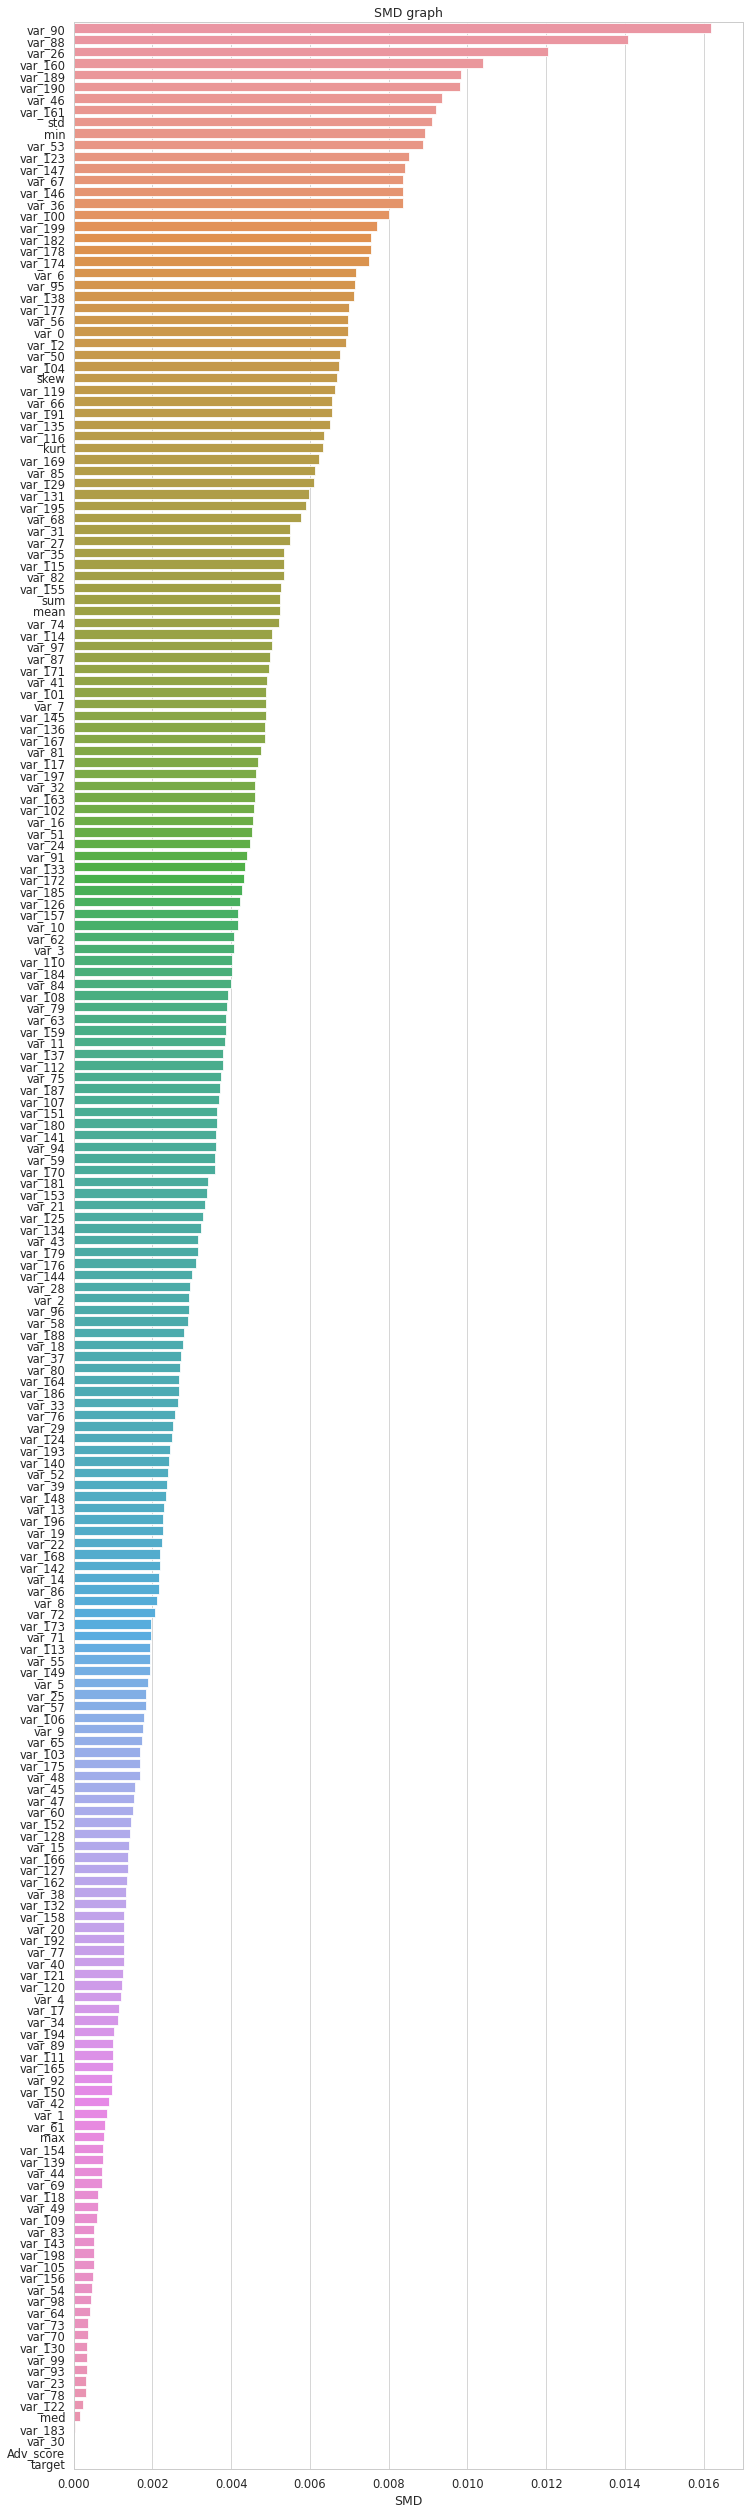

In [68]:
# smd
sort_smd = smd.sort_values(ascending=False)
dist_plot(sort_smd, "SMD")

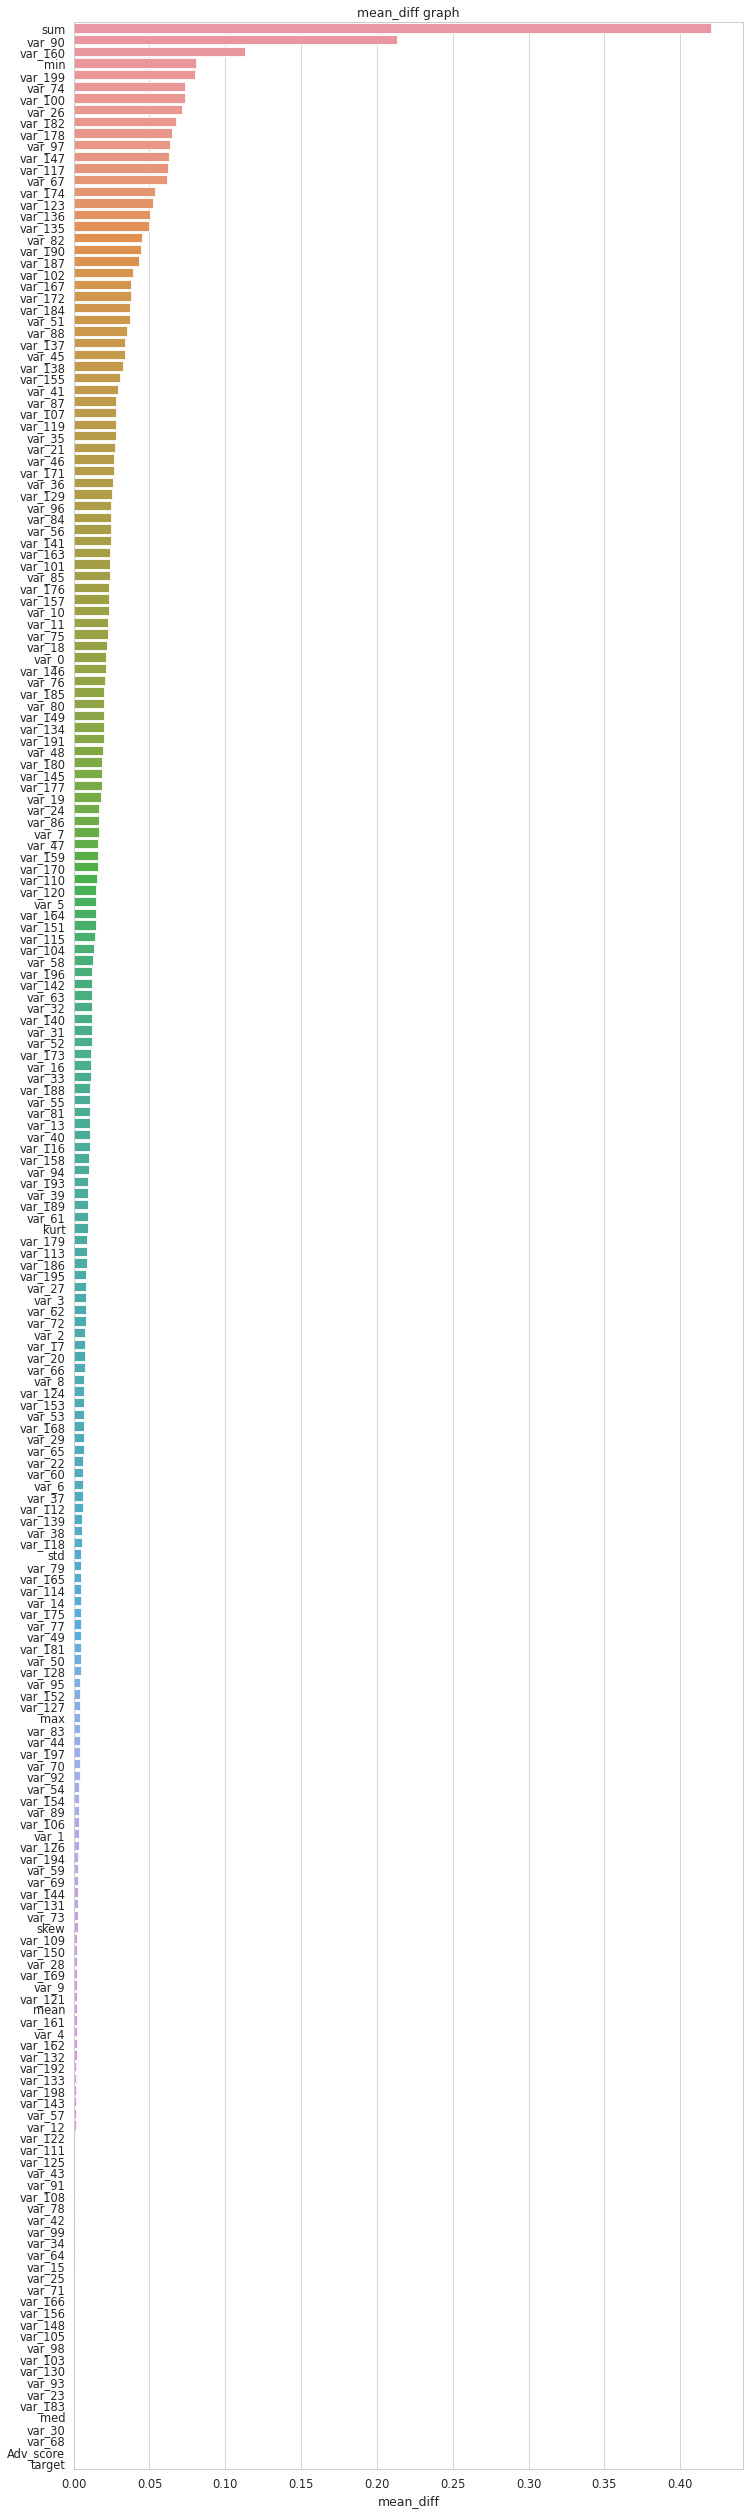

In [106]:
sort_mean_diff = mean_diff.sort_values(ascending=False)
dist_plot(sort_mean_diff, "mean_diff")

In [69]:
train_x.head()

var_0   var_1    var_2    var_3    var_4    var_5   var_6    var_7  \
15172   10.2221  1.9434  13.6975   6.1976   8.1854 -11.1479  5.1042  13.1142   
38531   15.8760  1.3697   8.0499   6.8944  12.4163 -11.5702  5.9761  16.0108   
105116  11.7707 -0.4345  12.3102   7.9781  11.8596  -8.4272  4.6101  11.1535   
108931   8.0403 -8.0066  11.8836   9.2145  13.6201 -17.0730  6.6237  14.0818   
77928    9.0248 -1.2113   6.7503  10.7419  13.4666   6.4088  6.1458  17.7492   

         var_8   var_9  ...        sum      min      max      mean        std  \
15172   0.4441  8.2086  ...  1412.1687 -24.1286  38.4920  7.060843   9.370668   
38531  -5.7000  9.6026  ...  1339.3370 -27.5576  41.7659  6.696685   9.454454   
105116 -3.6385  5.9036  ...  1291.1457 -21.3257  37.3033  6.455728  10.605060   
108931 -3.0050  4.9813  ...  1386.3506 -22.0344  33.0660  6.931753   9.334530   
77928  -1.4452  8.4921  ...  1236.0812 -49.6042  36.3969  6.180406   9.974401   

            skew      kurt      med  Adv_score  target  
15172   0.194266  1.487859  6.56845   0.561403       0  
38531  -0.123725  2.149360  7.15150   0.559447       0  
105116 -0.060890  0.620665  6.74035   0.558324       0  
108931 -0.233237  0.923900  7.53905   0.557683       0  
77928  -0.905923  5.072067  6.27915   0.556983       0  

[5 rows x 210 columns]

In [70]:
# 傾向スコアの算出
def propensity_plot(df1,col):
    feature = df1.columns

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    sns.distplot(df1[df1['adv_target'] == 1][feature[col]], bins=120, color='red')
    sns.distplot(df1[df1['adv_target'] == 0][feature[col]], bins=120, color='blue')
    ax.set(xlabel ="feature : " + str(feature[col]))
    plt.savefig("propensity.png", format="png", dpi=500)
    plt.show()

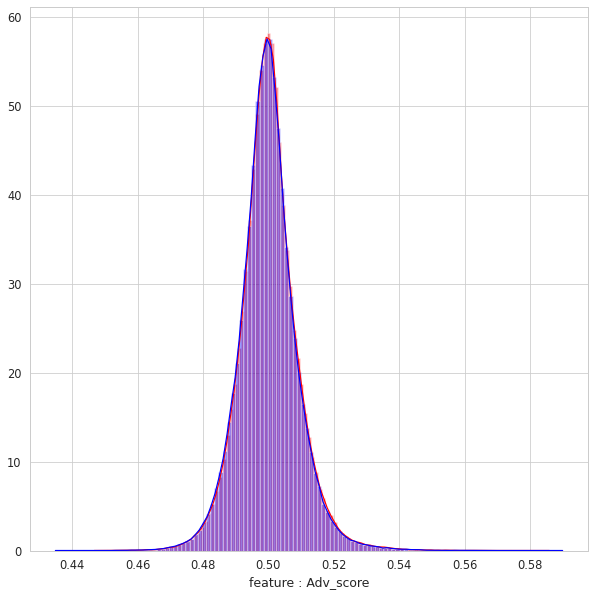

In [71]:
propensity_plot(train,209)

(0.0, 0.03)

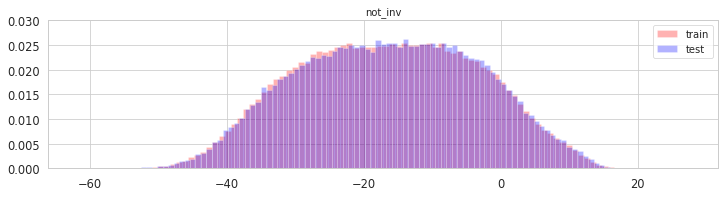

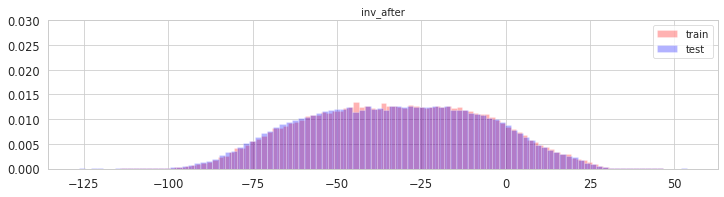

In [73]:
col = "var_90" 
ps_col = 'pred_{}'.format(L_model)


# test
df_test = train.loc[train['adv_target'] == 1][[col, 'Adv_score']]
# train
df_train = train.loc[train['adv_target'] == 0][[col, 'Adv_score']]

# 確率の逆数をかけた補正
x_test_inv = df_train[col] / df_train['Adv_score']
x_train_inv = df_test[col] / (1 - df_test['Adv_score'])

fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(211)
bins = 100
ax.hist(df_train[col], bins=bins, color='red', alpha=0.3, label='train', density=True)
ax.hist(df_test[col], bins=bins, color='blue', alpha=0.3, label='test', density=True)
ax.legend(prop={'size': 10})
ax.set_title('not_inv', fontdict={'fontsize': 10})
#ax.set_xlim(0, 100)
ax.set_ylim(0, 0.030)

fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(212)
bins = 100
ax.hist(x_train_inv, bins=bins, color='red', alpha=0.3, label='train', density=True)
ax.hist(x_test_inv, bins=bins, color='blue', alpha=0.3, label='test', density=True)
ax.legend(prop={'size': 10})
ax.set_title('inv_after', fontdict={'fontsize': 10})
#ax.set_xlim(0, 100)
ax.set_ylim(0, 0.030)


In [75]:
Y = train['var_90']
Z = train['adv_target']

PS = train['Adv_score']

# IPWの算出
IPW1 = sum(Z * Y / PS) / sum(Z / PS)
IPW0 = sum(((1 - Z) * Y) / (1 - PS)) / sum((1 - Z) / (1 -PS))
effect = IPW1 - IPW0

print('IPW_effect:{}'.format(effect))

IPW_effect:0.11932591563796535


In [89]:
def IPW_score(df):
    features = df.columns
    effects = []
    for feature in tqdm(features):
        
        Y = df[feature]
        Z = df['adv_target']

        PS = df['Adv_score']

        # IPWの算出
        IPW1 = sum(Z * Y / PS) / sum(Z / PS)
        IPW0 = sum(((1 - Z) * Y) / (1 - PS)) / sum((1 - Z) / (1 - PS))
        effect = IPW1 - IPW0
        effects.append(abs(effect))
        #print('IPW_effect:{}'.format(effect))
    
    return effects

In [94]:
effects = IPW_score(train)

100%|██████████| 210/210 [00:27<00:00,  7.54it/s]


In [104]:
effect_df = pd.DataFrame({"col":train.columns[0:208], "effects":effects[0:208]})
effect_df = effect_df.sort_values("effects",ascending=False)

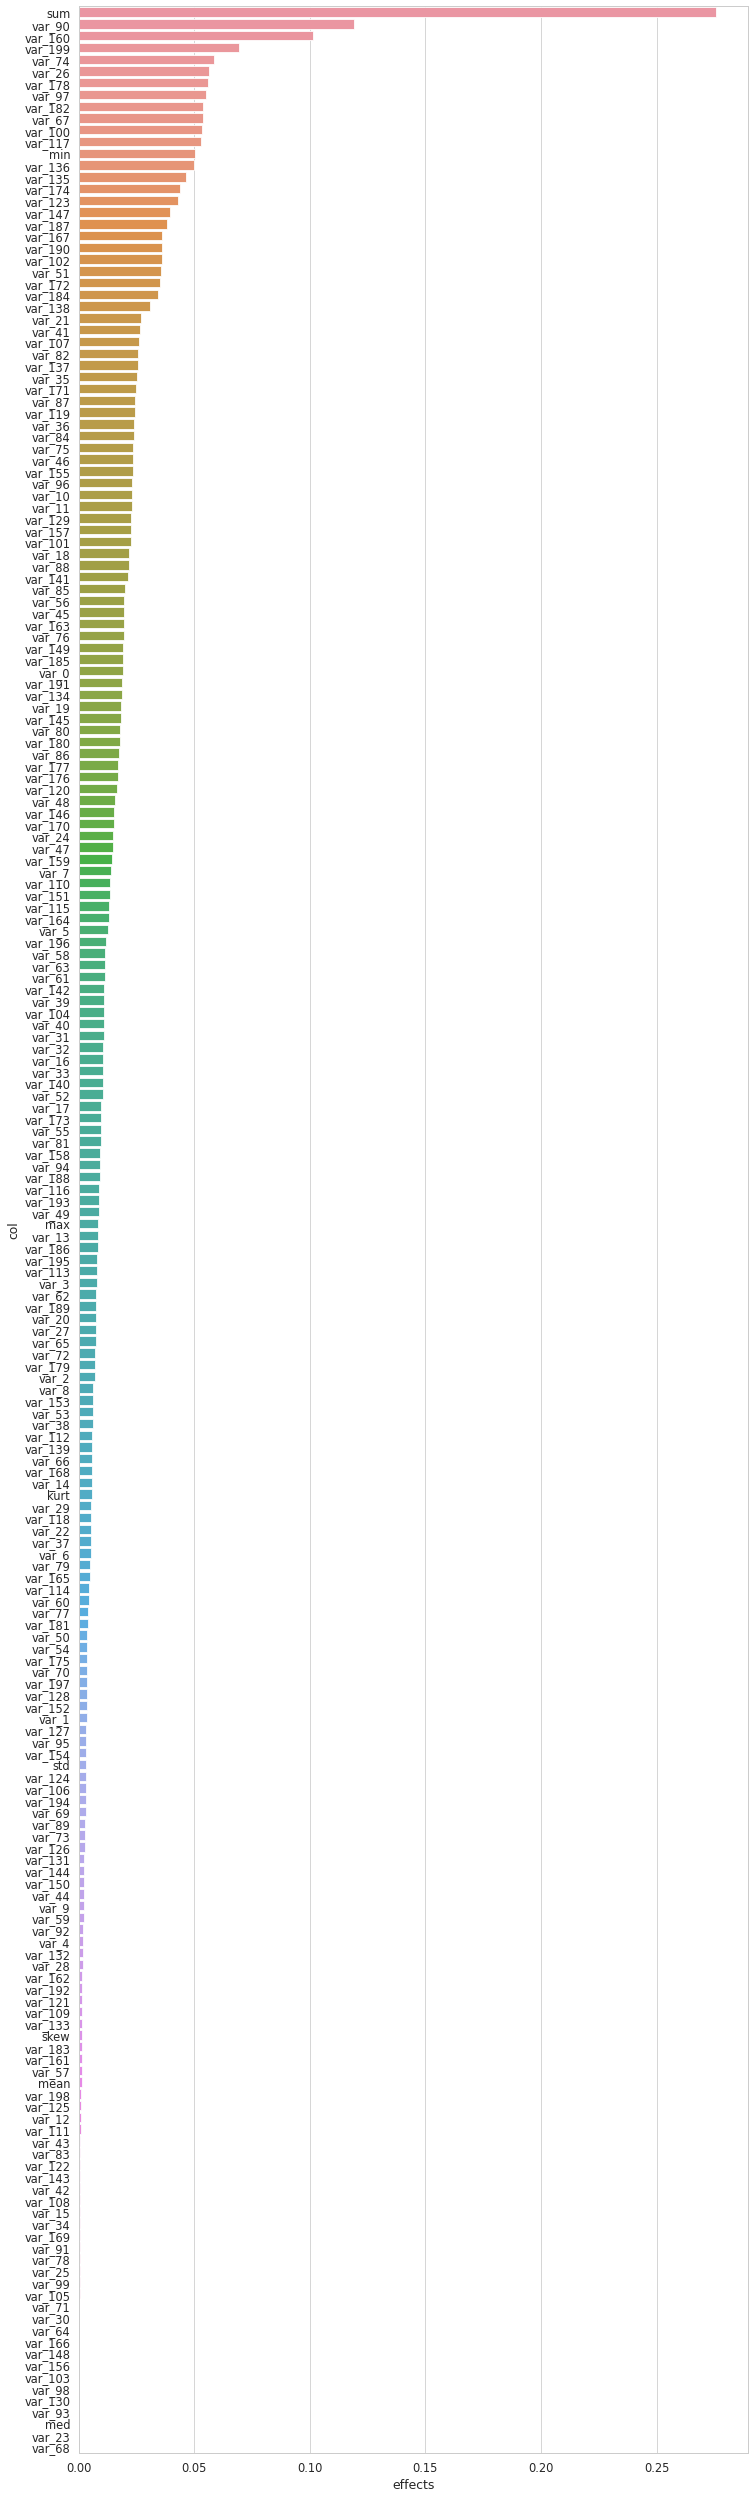

In [105]:
sns.set_context("paper", 1.3)
fig = plt.figure(figsize=(12,45))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(111)

sns.barplot(effect_df["effects"],effect_df["col"])

In [ ]:
ストップ

### test check
プログラムの確認場所(みなくてよい、何もない)

In [ ]:
# 各分布の可視化準化平均差
def two_dist_plot(df1,df2):
    feature = df1.columns

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    sns.distplot(df1[feature[200]], bins=50)
    sns.distplot(df2[feature[200]], bins=50)
    ax.set(xlabel ="feature : " + str(feature[200]), ylabel='Total amount of item')

In [ ]:
two_dist_plot(train_x,test_x)

In [ ]:
def SMD(df1,df2):
    # feature = df1.columns
    # 論文内ではSMD < 0.1が推奨されていた
    
    mean1 = df1.mean()
    mean2 = df2.mean()
    var1 = df1.var()
    var2 = df2.var()
    
    for i in range(len(mean1)):
        mean_diff = abs(mean1 - mean2)
        sd = np.sqrt((var1 + var2) / 2)
        smd = mean_diff / sd
    
    print("平均の差\n",mean_diff)
    print("\nSMD\n",smd)
    
    return mean_diff, smd

In [ ]:
mean_diff, smd = SMD(train_x,test_x)

In [ ]:
def dist_plot(df, gtext):
    fig = plt.figure(figsize=(12,40))
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(111)

    sns.barplot(df,df.index)
    ax.set_yticks(np.arange(len(df)))
    ax.set_xlabel(gtext)
    ax.set_title(gtext + ' graph')
    plt.savefig(gtext + ".png", format="png", dpi=500)
    plt.show()

In [ ]:
# smd
sort_smd = smd.sort_values(ascending=False)
dist_plot(sort_smd, "SMD")

In [ ]:
# あんまりかな？
sort_mean_diff = mean_diff.sort_values(ascending=False)
dist_plot(sort_mean_diff, "mean_diff")